# Attempt to reduce surface fresh bias

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import sys
sys.path.append('/home/users/birgal/')

from nemo_python_git.utils import convert_to_teos10, distance_btw_points, closest_point
from nemo_python_git.plots import circumpolar_plot, finished_plot

In [7]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
ref_folder    = f'{base_dir}output/ERA5_test6/files_spinup/'
noicb_folder  = f'{base_dir}output/ERA5_icebergs_off/files/'
ediff_folder  = f'{base_dir}output/ERA5_eddy_diff_up/files/'
edmin_folder  = f'{base_dir}output/ERA5_eddy_diff_minup/files/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

In [3]:
def plot_land(nemo_mesh, file_var):
    lon_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, file_var.values)
    return lon_plot, lat_plot, plot_var 

## Look at maps of spatial differences in surface salinity

In [9]:
nemo_mesh_ds = xr.open_dataset(nemo_mesh)
mesh_sub     = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)

In [100]:
kwags = {'x_grid_T':slice(450,900), 'y_grid_T':slice(130,350)}
ds_noicb = xr.open_dataset(f'{noicb_folder}eANT025.L121_1m_20100101_20101231_grid_T.nc').isel(**kwags)
ds_ref   = xr.open_dataset(f'{ref_folder}eANT025.L121_1m_20100101_20101231_grid_T.nc').isel(**kwags)

In [101]:
def plot_diff_tworuns(run1, run2, vmin=None, vmax=None, vdiff=None, title1='', title2=''):
    
    fig, ax = plt.subplots(1,3, figsize=(15,4), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=100)
    
    img1 = ax[0].pcolormesh(mesh_sub.nav_lon.values, mesh_sub.nav_lat.values, run1.sosss.values, 
                            transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.deep_r, vmin=vmin, vmax=vmax)
    ax[0].set_title(title1);
    img2 = ax[1].pcolormesh(mesh_sub.nav_lon.values, mesh_sub.nav_lat.values, run2.sosss.values, 
                            transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.deep_r, vmin=vmin, vmax=vmax)
    ax[1].set_title(title2);
    img3 = ax[2].pcolormesh(mesh_sub.nav_lon.values, mesh_sub.nav_lat.values, (run2.sosss - run1.sosss).values, 
                            transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.balance, vmin=-1*vdiff, vmax=vdiff)
    ax[2].set_title('Difference');

    for axis in ax.ravel():
        axis.set_extent([-95, -135, -76, -68], ccrs.PlateCarree());
        gl = axis.gridlines(draw_labels=True);
        gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
        
    cax1 = fig.add_axes([0.05, 0.25, 0.015, 0.5])
    cax2 = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    plt.colorbar(img1, cax=cax1, extend='both')
    plt.colorbar(img3, cax=cax2, extend='both')
    
    return fig, ax

In [102]:
def plot_seasonal_diff_tworuns(run1, run2, vdiff=None):
    
    fig, ax = plt.subplots(3,4, figsize=(18,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=100)
    
    for n, axis in enumerate(ax.ravel()):
        axis.set_extent([-95, -135, -76, -68], ccrs.PlateCarree());
        gl = axis.gridlines(draw_labels=True);
        gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
        
        img1 = axis.pcolormesh(mesh_sub.nav_lon.values, mesh_sub.nav_lat.values, (run2.sosss - run1.sosss).isel(time_counter=n).values, 
                               transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.balance, vmin=-1*vdiff, vmax=vdiff)

        axis.set_title(f'Month: {n+1}')

    cax1 = fig.add_axes([0.04, 0.35, 0.015, 0.3])
    plt.colorbar(img1, cax=cax1, extend='both')
    
    return fig, ax

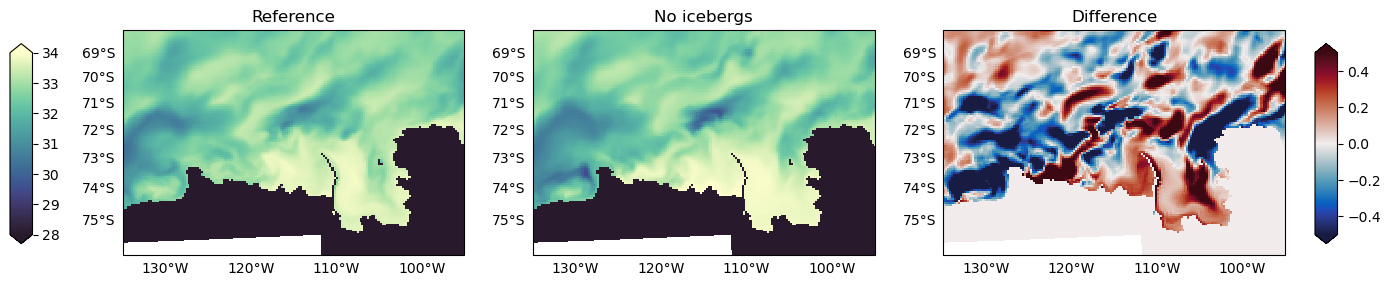

In [103]:
fig, ax = plot_diff_tworuns(ds_ref.isel(time_counter=0), ds_noicb.isel(time_counter=0), 
                            vmin=28, vmax=34, vdiff=0.5, title1='Reference', title2='No icebergs')

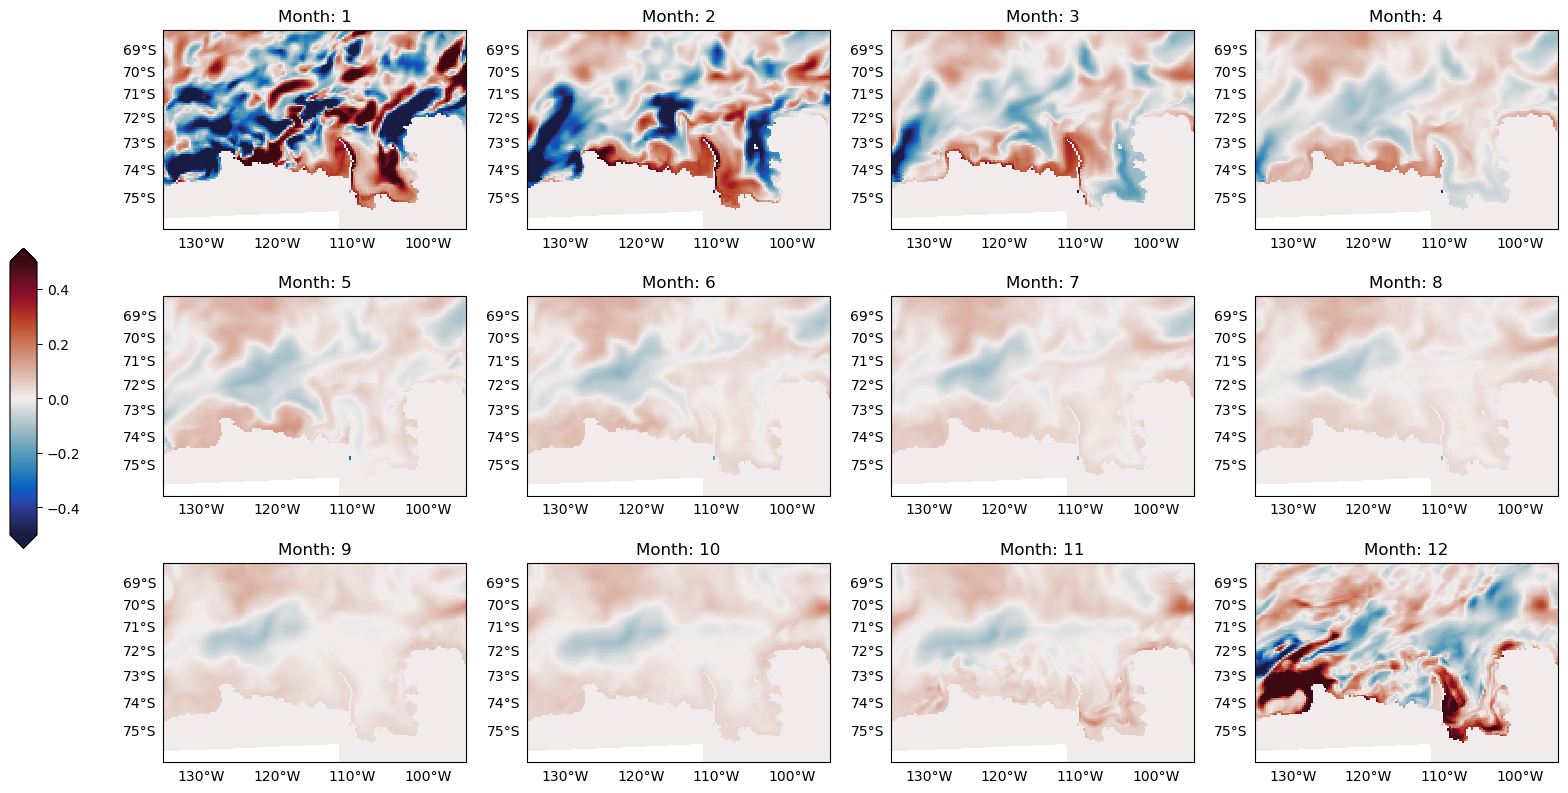

In [104]:
fig, ax = plot_seasonal_diff_tworuns(ds_ref, ds_noicb, vdiff=0.5)

In [105]:
kwags = {'x_grid_T':slice(450,900), 'y_grid_T':slice(130,350)}
ds_eddy_up    = xr.open_dataset(f'{ediff_folder}eANT025.L121_1m_19800101_19801231_grid_T.nc').isel(**kwags)
ds_eddy_minup = xr.open_dataset(f'{edmin_folder}eANT025.L121_1m_19800101_19801231_grid_T.nc').isel(**kwags)
ds_ref        = xr.open_dataset(f'{ref_folder}eANT025.L121_1m_19800101_19801231_grid_T.nc').isel(**kwags)

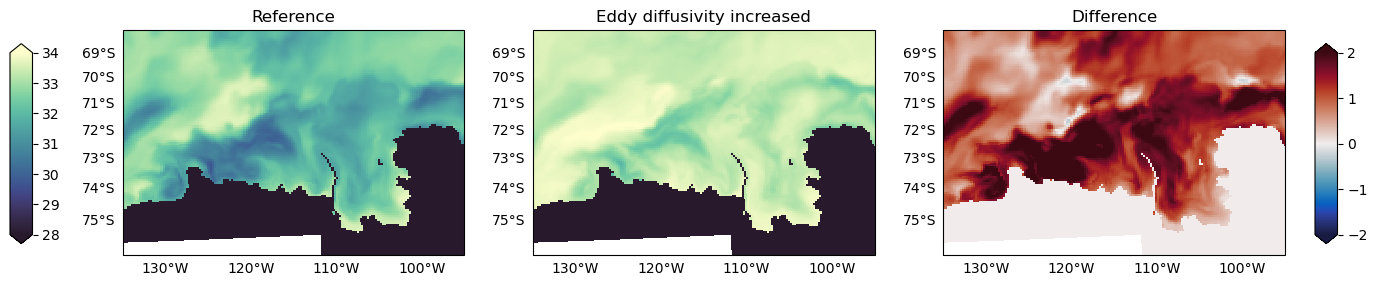

In [106]:
fig, ax = plot_diff_tworuns(ds_ref.isel(time_counter=0), ds_eddy_up.isel(time_counter=0), 
                            vmin=28, vmax=34, vdiff=2, title1='Reference', title2='Eddy diffusivity increased')

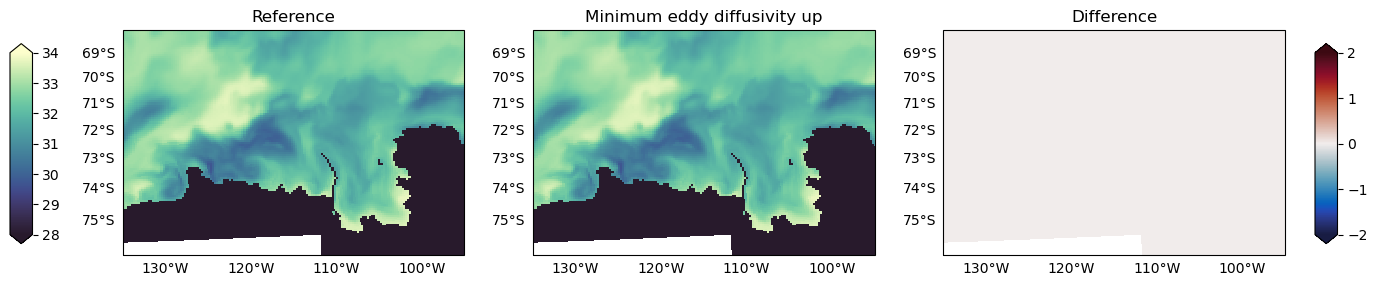

In [107]:
fig, ax = plot_diff_tworuns(ds_ref.isel(time_counter=0), ds_eddy_minup.isel(time_counter=0), 
                            vmin=28, vmax=34, vdiff=2, title1='Reference', title2='Minimum eddy diffusivity up')

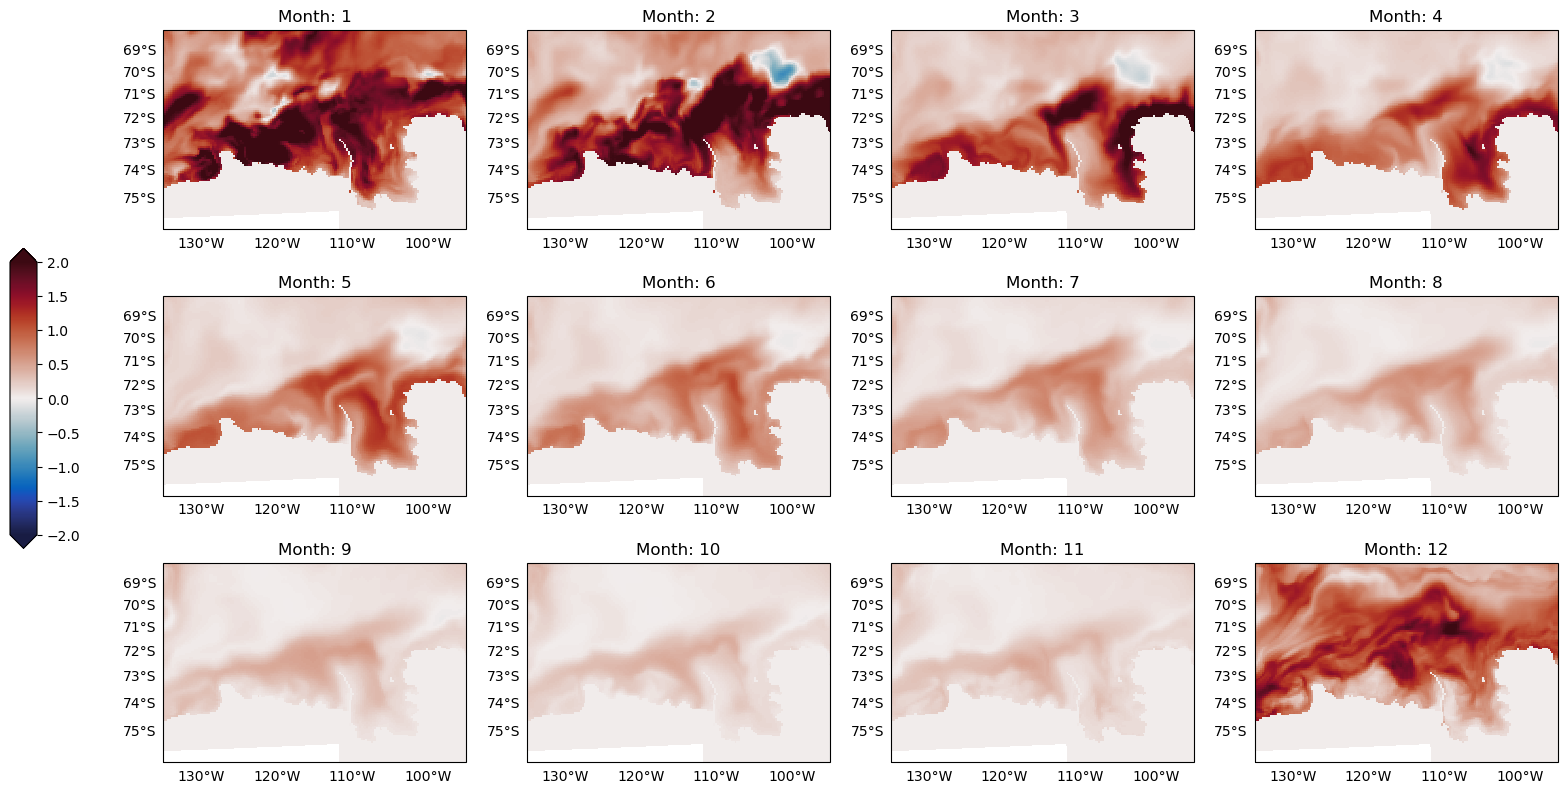

In [108]:
fig, ax = plot_seasonal_diff_tworuns(ds_ref, ds_eddy_up, vdiff=2.0)